# Step 2: Filtering Fasta Sequences

### Import packages, Assign Variables

In [1]:
from Bio import SeqIO
from matplotlib import pyplot as plt
import os
import numpy as np

In [2]:
# this block is used to define variables to be used later
fasta_file_path = "../1-get_cycog/data/CyCOG_60000117.prfg.faa"  # Add your FASTA file path here
# tolerance will either be a chosen number of amino acids or based on the standard deviation of sequence length
# tolerance = (0, 0)
tolerance = "std"


### The block below takes a fasta inputted and displays a histogram showing the sequence length distribution within the fasta.

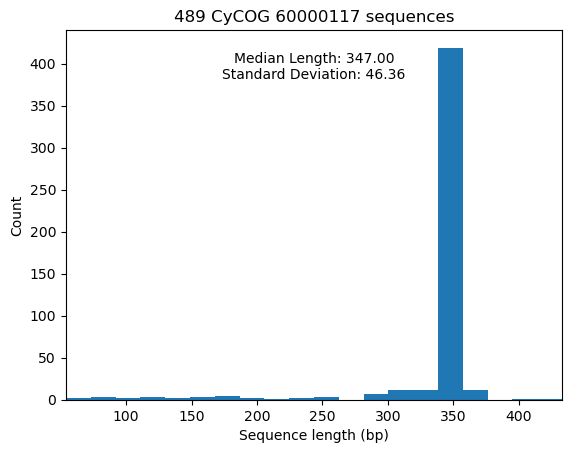

In [3]:

# Extract the number before the first dot in the file name
cycog_number = os.path.basename(fasta_file_path).split("_")[1].split(".")[0]

# Parse the FASTA file and get sequence lengths
sizes = [len(rec) for rec in SeqIO.parse(fasta_file_path, "fasta")]

# Parse the input FASTA file and calculate median and standard deviation
sequences = []
for seq_record in SeqIO.parse(fasta_file_path, "fasta"):
    sequences.append(seq_record)
sequence_lengths = np.array([len(seq) for seq in sequences])
median_length = np.median(sequence_lengths)
std_dev = np.std(sequence_lengths)
lower_lim = sequence_lengths.min()
upper_lim = sequence_lengths.max()



# Plot histogram
plt.hist(sizes, bins=20)
plt.title(f"{len(sizes)} CyCOG {cycog_number} sequences")
plt.xlabel("Sequence length (bp)")
plt.ylabel("Count")
plt.xlim((lower_lim,upper_lim))

# Annotate median and standard deviation on the histogram
plt.text(0.5, 0.9, f'Median Length: {median_length:.2f}\nStandard Deviation: {std_dev:.2f}',
           horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()


### The block below makes a new fasta, filtering out sequences outside of one standard deviation from the median length.

In [11]:
# Define filter limits
if tolerance == "std":
    tol_low = std_dev
    tol_high = std_dev
else:
    tol_low = tolerance[0]
    tol_high = tolerance[1]

# Define output file path based on CyCOG number
output_fasta_path = os.path.join("data", f"{cycog_number}_filtered.fasta")

# Filter sequences based on one standard deviation from the median
filtered_sequences = [seq for seq in sequences if len(seq) >= median_length - tol_low and len(seq) <= median_length + tol_high]

# Write filtered sequences to the output FASTA file
with open(output_fasta_path, "w") as output_file:
    SeqIO.write(filtered_sequences, output_file, "fasta")


print(f"Filtered fasta saved to {output_fasta_path}")

Filtered fasta saved to data/60000117_filtered.fasta


### The block below makes a new histogram with the new fasta and saves it.

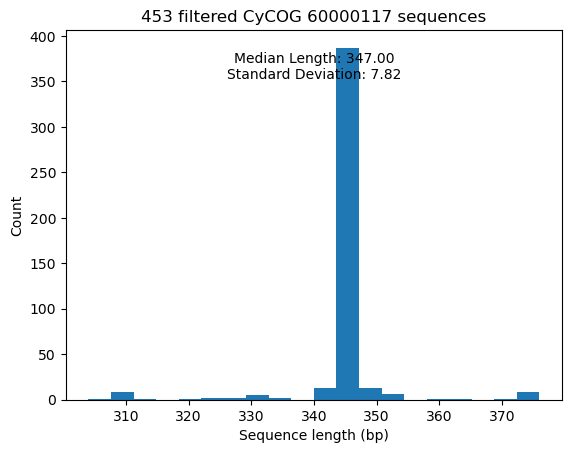

In [5]:
# Calculate median and standard deviation
sequence_lengths = np.array([len(seq) for seq in filtered_sequences])
median_length = np.median(sequence_lengths)
std_dev = np.std(sequence_lengths)

# Plot histogram
plt.hist(sequence_lengths, bins=20)
plt.title(f"{len(sequence_lengths)} filtered CyCOG {cycog_number} sequences")
plt.xlabel("Sequence length (bp)")
plt.ylabel("Count")
# plt.xlim((lower_lim,upper_lim)) #use this line if you want to use the first plot x axis range

# Annotate median and standard deviation on the histogram
plt.text(0.5, 0.9, f'Median Length: {median_length:.2f}\nStandard Deviation: {std_dev:.2f}',
           horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Save the histogram output inside the "data" directory
output_histogram_path = os.path.join("data", f"{cycog_number}_hist.png")
plt.savefig(output_histogram_path, bbox_inches='tight')

plt.show()


# Step 3: Aligning CyCOG - Work in Progress

The code below is an attempt at conducting an alignment within a jupyter notebook. It appears that alignment is not recommended for use within a notebook, and is preferentially conducted on the command-line or a third-party software.
I will attempt to add a script for use in the command-line, placing its code within this notebook for reference.

In [ ]:
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import MuscleCommandline

# Define the input and output file paths
# input_file = "data/60000117_filtered.fasta"
output_file = "aligned_sequences.fasta"

# Read sequences from the input FASTA file
sequences = list(SeqIO.parse(output_fasta_path, "fasta"))

# Perform sequence alignment using Muscle
muscle_cline = MuscleCommandline(input=input_file)
stdout, stderr = muscle_cline()

# Parse the aligned sequences
aligned_sequences = list(SeqIO.parse(output_file, "fasta"))

# Print the aligned sequences
print("Aligned sequences:")
for seq in aligned_sequences:
    print(f">{seq.id}")
    print(seq.seq)

# Save the aligned sequences to a new file
SeqIO.write(aligned_sequences, "aligned_sequences.fasta", "fasta")

print("Alignment saved to aligned_sequences.fasta")


# Step 4: Trim Alignment

### Import Packages, Assign Variables

In [8]:
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
import os

In [9]:
alignment_file_path = "../4-trim_realign/data/Aligned_fastas/prfg-aligned.faa" #filepath to aligned fasta
alignment = AlignIO.read(alignment_file_path, "fasta")
cycog_id = os.path.basename(alignment_file_path).split("-")[0] #used to name file outputs



In [14]:
def slice_alignment(alignment):
    # Get the alignment length
    alignment_length = alignment.get_alignment_length()

    # Set the threshold for % non-gap characters needed for signifigance
    threshold = int(0.95 * len(alignment)) #integer represents proportion of non-gap characters, 0.95 is 95%

    # Find the first and last columns meeting the threshold, establish empty variables to be filled
    first_non_gap_col = None
    last_non_gap_col = None
    
        #fill the variables:
        
    for col in range(alignment_length):
        if sum(seq[col] != '-' for seq in alignment) >= threshold:
            first_non_gap_col = col
            break

    for col in range(alignment_length - 1, -1, -1):
        if sum(seq[col] != '-' for seq in alignment) >= threshold:
            last_non_gap_col = col
            break

    # Check if both first and last columns meeting the threshold are found
    if first_non_gap_col is not None and last_non_gap_col is not None:
        # Slice out the gappy regions at the start and end of the alignment
        sliced_alignment = alignment[:, first_non_gap_col:last_non_gap_col + 1]
    else:
        sliced_alignment = None  # Return None if no columns meeting the threshold are found

    return sliced_alignment

# Slice off the gappy regions at the start and end of the alignment
sliced_alignment = slice_alignment(alignment)

# Check if the sliced alignment is not None
if sliced_alignment is not None:
    # Save the sliced alignment to a file in the data directory
    trim_align_path = os.path.join("../4-trim_realign/data", f"{cycog_id}_trim_algn.fasta")


    AlignIO.write(sliced_alignment, trim_align_path, "fasta")
    print(f"Sliced alignment saved to {trim_align_path}")
else:
    print("No columns meeting the 95% non-gap threshold found in the alignment.")

Sliced alignment saved to ../4-trim_realign/data/prfg_trim_algn.fasta
